In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sb
import numpy as np
import math
from matplotlib import pyplot as plt

from IPython.display import clear_output
from ipywidgets import interactive
import ipywidgets as widgets

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score


In [2]:
#reading in csv files that we will use
multi_df = pd.read_csv('Multi_Value_Numbeo.csv') 
quality_df = pd.read_csv('Quality_of_Life_Numbeo.csv')
property_df = pd.read_csv('Property_Prices_Numbeo.csv')

move_df = pd.read_csv('movehubqualityoflife.csv')

# Data Cleaning, Joining, & Creating the DF to model and visualize data with

In [3]:
#Checking to see if there are any null - empty values in dataset
print(multi_df.isnull().sum())
print("-----------------------------------")
print(quality_df.isnull().sum())
print("-----------------------------------")
print(property_df.isnull().sum())
print("-----------------------------------")
print(move_df.isnull().sum())

Rank                            0
City                            0
Cost of Living Index            0
Rent Index                      0
Cost of Living Plus Rent        0
Groceries Index                 0
Resaurant Price Index           0
Local Purchasing Power Index    0
dtype: int64
-----------------------------------
Rank                              0
City                              0
Quality of Life Index             0
Purchasing Power Index            0
Safety Index                      0
Health Care Index                 0
Cost of Living Index              0
Property Price to Income Ratio    0
Traffic Commute Time Index        0
Pollution Index                   0
Climate Index                     0
dtype: int64
-----------------------------------
Rank                                          0
City                                          0
Price To Income Ratio                         0
Gross Rental Yield City Centre                0
Gross Rental Yield Outside of Centre      

In [4]:
#checking to see how many rows are in the df
print("Multi_df",multi_df.shape[0])
print("Quality_df",quality_df.shape[0])
print("Property_df",property_df.shape[0])
print("move_df",move_df.shape[0])

Multi_df 573
Quality_df 250
Property_df 480
move_df 216


if 'Adelaide, Australia' not in multi_df.City:
    print("yes")

In [5]:
move_df.head(2)

,City,Movehub Rating,Purchase Power,Health Care,Pollution,Quality of Life,Crime Rating,lat,lng
0,Caracas,65.18,11.25,44.44,83.45,8.61,85.70,10.480594,-66.903606
1,Johannesburg,84.08,53.99,59.98,47.39,51.26,83.93,-26.204103,28.047305


In [6]:
#drop rank because they are unneccesary to us
multi_df = multi_df.drop("Rank",axis=1)
quality_df = quality_df.drop("Rank",axis=1)
property_df = property_df.drop("Rank",axis=1)

In [7]:
#join inner
df = pd.merge(multi_df, property_df, on='City')

In [8]:
#looking at shape after join
df.shape[0]

440

In [9]:
#join inner
df_withLife = pd.merge(df, quality_df,on='City')

In [10]:
df_withLife.shape[0]

241

In [11]:
df_withLife.head(2)

,City,Cost of Living Index_x,Rent Index,Cost of Living Plus Rent,Groceries Index,Resaurant Price Index,Local Purchasing Power Index,Price To Income Ratio,Gross Rental Yield City Centre,Gross Rental Yield Outside of Centre,...,Affordability Index,Quality of Life Index,Purchasing Power Index,Safety Index,Health Care Index,Cost of Living Index_y,Property Price to Income Ratio,Traffic Commute Time Index,Pollution Index,Climate Index
0,"Zurich, Switzerland",132.00,65.85,100.30,133.03,120.68,123.01,8.10,3.29,3.80,...,2.18,199.53,123.01,83.87,75.94,132.00,8.10,33.53,16.63,81.48
1,"Geneva, Switzerland",128.14,66.41,98.56,127.77,119.58,114.18,9.25,3.23,3.55,...,1.83,186.60,114.18,72.59,73.08,128.14,9.25,25.49,25.99,82.61


In [12]:
#extracting city column into two - city name and country 
df_withLife['City Name']=df_withLife['City'].str.extract(r'([^,]+)')
df_withLife['Country']=df_withLife['City'].str.extract(r'([^,]*$)')

In [13]:
df_withLife = df_withLife.drop("Cost of Living Index_y",1)
print(move_df.shape[0])
print(move_df.columns)

216
Index(['City', 'Movehub Rating', 'Purchase Power', 'Health Care', 'Pollution',
       'Quality of Life', 'Crime Rating', 'lat', 'lng'],
      dtype='object')


In [14]:
move_df = move_df.rename(columns={"City" : "City Name"})


In [15]:
#join numbeo dataframes with movehub df
merged_df = pd.merge(df_withLife, move_df, on='City Name',how='inner')

In [16]:
print(merged_df.shape[0])
print(merged_df.isnull().sum())

160
City                                          0
Cost of Living Index_x                        0
Rent Index                                    0
Cost of Living Plus Rent                      0
Groceries Index                               0
Resaurant Price Index                         0
Local Purchasing Power Index                  0
Price To Income Ratio                         0
Gross Rental Yield City Centre                0
Gross Rental Yield Outside of Centre          0
Price To Rent Ratio City Centre               0
Price To Rent Ratio Outside Of City Centre    0
Mortgage As A Percentage Of Income            0
Affordability Index                           0
Quality of Life Index                         0
Purchasing Power Index                        0
Safety Index                                  0
Health Care Index                             0
Property Price to Income Ratio                0
Traffic Commute Time Index                    0
Pollution Index                     

In [17]:
#This column is an estimation of consumer goods prices including rent comparing to New York City so we will drop this and take the one from movehub
#The movehub Power Purchasing column is comparing average cost of living with the average local wage which is more realistic if we
#use this column because if you move to a city and live there - more than likely to work there
merged_df = merged_df.drop("Local Purchasing Power Index",1)

In [18]:
#take the two columns for pollution
df_pollution = pd.DataFrame(list(zip(merged_df['Pollution Index'],merged_df['Pollution'])),columns=["Pollution Index","Pollution"])

#return biggest value into new column pollution max
merged_df['Pollution Max'] = df_pollution.apply(max, axis=1)
merged_df = merged_df.drop("Pollution",1)

In [19]:
merged_df['Health Care Mean'] = merged_df[['Health Care Index', 'Health Care']].mean(axis=1)
merged_df = merged_df.drop('Health Care Index',1)
merged_df = merged_df.drop('Health Care',1)

In [20]:
merged_df.columns

Index(['City', 'Cost of Living Index_x', 'Rent Index',
       'Cost of Living Plus Rent', 'Groceries Index', 'Resaurant Price Index',
       'Price To Income Ratio', 'Gross Rental Yield City Centre',
       'Gross Rental Yield Outside of Centre',
       'Price To Rent Ratio City Centre',
       'Price To Rent Ratio Outside Of City Centre',
       'Mortgage As A Percentage Of Income', 'Affordability Index',
       'Quality of Life Index', 'Purchasing Power Index', 'Safety Index',
       'Property Price to Income Ratio', 'Traffic Commute Time Index',
       'Pollution Index', 'Climate Index', 'City Name', 'Country',
       'Movehub Rating', 'Purchase Power', 'Quality of Life', 'Crime Rating',
       'lat', 'lng', 'Pollution Max', 'Health Care Mean'],
      dtype='object')

In [21]:
merged_df = merged_df.rename(columns={"Pollution Max" : "Pollution", "Health Care Mean" : "Health Care", "Cost of Living Plus Rent" : "Cost of Living","Traffic Commute Time Index" : "Traffic Time Index"})

In [22]:
merged_df = merged_df[['City Name','Country','Purchase Power','Pollution','Health Care','Quality of Life','Cost of Living','Safety Index','Crime Rating','Climate Index','Traffic Time Index','lat','lng']]
merged_df

,City Name,Country,Purchase Power,Pollution,Health Care,Quality of Life,Cost of Living,Safety Index,Crime Rating,Climate Index,Traffic Time Index,lat,lng
0,Zurich,Switzerland,79.58,18.04,77.135,97.91,100.30,83.87,15.35,81.48,33.53,47.376887,8.541694
1,Geneva,Switzerland,61.22,29.43,73.980,82.76,98.56,72.59,54.36,82.61,25.49,46.204391,6.143158
2,New York,United States,55.56,59.11,56.490,61.94,100.00,53.84,47.33,79.66,43.13,40.712775,-74.005973
3,Oslo,Norway,52.51,29.39,81.725,71.27,68.95,64.16,35.53,59.99,31.92,59.913869,10.752245
4,Honolulu,United States,58.54,36.82,64.725,79.58,80.04,55.43,44.14,95.33,41.19,21.306944,-157.858333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,Pune,India,37.96,79.24,66.455,43.84,17.25,58.63,41.37,74.32,44.41,18.520430,73.856744
156,Kolkata,India,28.80,78.22,44.885,25.64,16.43,52.48,43.33,60.90,60.38,22.572646,88.363895
157,Chennai,India,32.91,78.07,69.410,43.89,16.43,59.50,33.22,53.22,47.98,13.082680,80.270718
158,Lahore,Pakistan,12.45,78.86,56.830,28.52,13.68,60.49,51.98,67.56,33.69,31.520370,74.358747


In [23]:
print(merged_df.columns)

Index(['City Name', 'Country', 'Purchase Power', 'Pollution', 'Health Care',
       'Quality of Life', 'Cost of Living', 'Safety Index', 'Crime Rating',
       'Climate Index', 'Traffic Time Index', 'lat', 'lng'],
      dtype='object')


In [24]:
merged_df.dtypes

City Name              object
Country                object
Purchase Power        float64
Pollution             float64
Health Care           float64
Quality of Life       float64
Cost of Living        float64
Safety Index          float64
Crime Rating          float64
Climate Index         float64
Traffic Time Index    float64
lat                   float64
lng                   float64
dtype: object

In [25]:
#encode city column values and give them actual int values 
merged_df["City Name"] = merged_df["City Name"].astype('category')
merged_df["City_Codes"] = merged_df["City Name"].cat.codes

In [26]:
merged_df.dtypes

City Name             category
Country                 object
Purchase Power         float64
Pollution              float64
Health Care            float64
Quality of Life        float64
Cost of Living         float64
Safety Index           float64
Crime Rating           float64
Climate Index          float64
Traffic Time Index     float64
lat                    float64
lng                    float64
City_Codes               int16
dtype: object

# Data Visualization

Text(0.5, 1, 'Correlation Map')

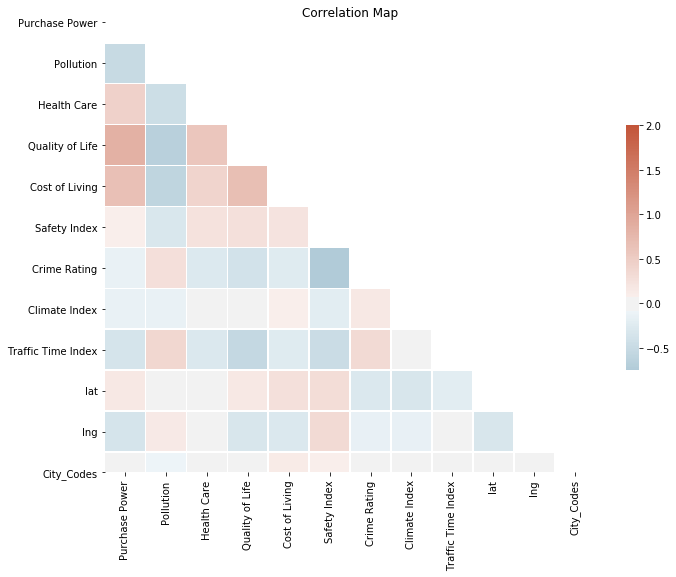

In [27]:
corr = merged_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sb.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sb.heatmap(corr, mask=mask, cmap=cmap, vmax=2, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Correlation Map")

interactive(children=(Dropdown(description='x', index=2, options=('Purchase Power', 'Pollution', 'Health Care'…

interactive(children=(Dropdown(description='y', index=6, options=('Purchase Power', 'Pollution', 'Health Care'…

Button(description='Graph', style=ButtonStyle())

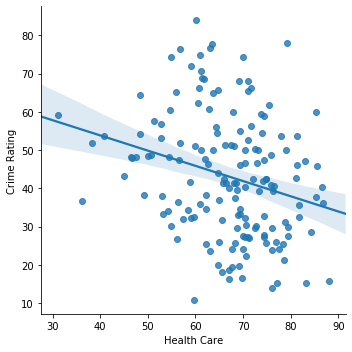

In [28]:
columns = ['Purchase Power', 'Pollution', 'Health Care',
       'Quality of Life', 'Cost of Living', 'Safety Index', 'Crime Rating',
       'Climate Index', 'Traffic Time Index', 'lat', 'lng']
listPlot = ['1','2','3','4']


def f(x):
    return x
def g(y):
    return y


def on_button_clicked(b):
        clear_output(True)
        display(w)
        display(z)
        display(sb.lmplot(w.result,z.result,data=merged_df))
        display(button)
        

    

w=interactive(f, x=columns)
z=interactive(g, y=columns)

display(w)
display(z)

button = widgets.Button(description="Graph")
display(button)
button.on_click(on_button_clicked)

# Getting Ready for Modeling

In [29]:
def bestList(listDF,prediction):
    for i in prediction:
        listDF.append(int(i))

In [30]:
modelCol= ['Purchase Power', 'Pollution', 'Health Care',
       'Quality of Life', 'Cost of Living', 'Safety Index', 'Crime Rating',
       'Climate Index', 'Traffic Time Index', 'lat', 'lng']

#basic first model

#selecting the prediction target 
y = merged_df.City_Codes

In [31]:
def modelButtonClickedDT(b):
        clear_output(True)
        display(modelButton)
        X = merged_df[list(modelButton.value)]
        train_X, val_X, train_y, val_y = train_test_split(X,y,random_state=0)
        #instantiating model specified with random_state = 1 to ensure same results each run
        df_model = DecisionTreeRegressor(random_state=0)
        #Fit model
        df_model.fit(train_X,train_y)
        #retrieve predicted city on validated data
        val_predictions = df_model.predict(val_X)
        print("Based on Decision Tree Regressor Best Predicted City (codes): ", val_predictions)
        
        forest_model = RandomForestRegressor(random_state=1)
        forest_model.fit(train_X, train_y)
        df_prediction = np.round(forest_model.predict(val_X))
        print("Based on Decision Tree Regressor Best Predicted City (codes): ", df_prediction)

        #plot the data
        display(sb.barplot(x=(list(modelButton.value)), y=(df_model.feature_importances_), palette="Blues_d"))
        plt.xticks(rotation=55)
        #retrieve predicted error on validated data Decision tree validated data
        dt_Error=mean_absolute_error(val_y, val_predictions)
        #retrieve predicted error on validated data Random Forest regressor validated data
        rf_Error=mean_absolute_error(val_y, df_prediction)
        
        print("Decision Tree MAE:", dt_Error)
        print("Random Forest MAE:", rf_Error)
        
        # plot feature importance
        plt.title("Feature(s) Factoring into Decision")
        display(buttonModel)



SelectMultiple(description='Features', index=(0, 2, 3), options=('Purchase Power', 'Pollution', 'Health Care',…

Based on Decision Tree Regressor Best Predicted City (codes):  [144.  15.  90.  18. 154.  76. 144. 140.   4. 115.  25. 119.  83.  59.
   4.  29.   6. 144. 122. 132.  24.  78. 138.  18. 148.  34.   2.  29.
  81.  25. 132.  48.  18. 147.   0. 140.  70.   2.   1. 151.]
Based on Decision Tree Regressor Best Predicted City (codes):  [111.  67.  87.  83.  78.  77. 106. 111.  56.  74.  54.  92. 114.  87.
  79.  35.  91.  86. 107. 105. 124.  58. 106.  49. 100.  28. 104.  57.
  78.  59.  87.  26.  54.  62.  78.  90.  87.  94.  24. 102.]


Decision Tree MAE: 63.725
Random Forest MAE: 44.425


Button(description='Predict', style=ButtonStyle())

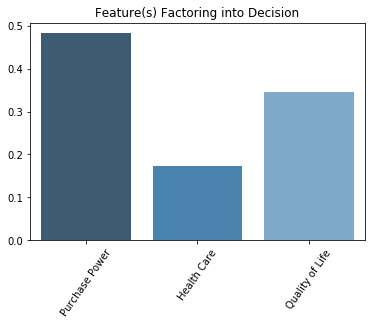

In [32]:
modelButton = widgets.SelectMultiple(
    options=modelCol,
    value=['Purchase Power'],
    rows=11,
    description='Features',
    disabled=False
)
display(modelButton)
buttonModel = widgets.Button(description="Predict")
display(buttonModel)
buttonModel.on_click(modelButtonClickedDT)

In [41]:
merged_df.loc[merged_df['City_Codes'] == 111]

,City Name,Country,Purchase Power,Pollution,Health Care,Quality of Life,Cost of Living,Safety Index,Crime Rating,Climate Index,Traffic Time Index,lat,lng,City_Codes
68,Ottawa,Canada,91.85,33.55,70.68,86.11,53.15,73.79,22.25,44.46,31.21,45.42153,-75.697193,111


# Using Cross-Validation </br>
This dataset is small so it doesn't matter if computing this takes a long time- running cross-validaiton is giving us a more accurate measure of model quality 

In [34]:
def bSlideClicked(b):
        clear_output(True)
        my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                                      ('model', RandomForestRegressor(n_estimators=crossInter.result,
                                                                      random_state=0))
                                     ])
        X = merged_df[list(modelButton.value)]
        MAE = -1 * cross_val_score(my_pipeline, X, y,
                                      cv=5,
                                      scoring='neg_mean_absolute_error')
        print("MAE:", MAE)
        print("Average MAE (across experiments):", MAE.mean())
        display(crossInter)
        display(buttonSlide)


In [35]:
crossInter = interactive(f, x=(0,100));
layout = widgets.Layout(width='auto', height='40px') #set width and height
buttonSlide =  widgets.Button(
    description='Compute Cross-Validation MAE',
    disabled=False,
    display='flex',
    flex_flow='column',
    align_items='stretch', 
    layout = layout
)        

display(crossInter)
display(buttonSlide)
buttonSlide.on_click(bSlideClicked)

interactive(children=(IntSlider(value=50, description='x'), Output()), _dom_classes=('widget-interact',))

Button(description='Compute Cross-Validation MAE', layout=Layout(height='40px', width='auto'), style=ButtonSty…